# Federated Learning of a Recurrent Neural Network

## 1. Step: Dependencies!

In [2]:
from __future__ import unicode_literals, print_function, division
from torch.utils.data import Dataset

import torch
from io import open
import glob
import os
import numpy as np
import unicodedata
import string
import random
import torch.nn as nn
import time
import math
import pandas as pd
import random
from tqdm import tqdm

import syft as sy
# from syft.frameworks.torch.fl import utils
# from syft.workers import WebsocketClientWorker
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
# Arguments for the program
class Arguments():
    def __init__(self):
        self.batch_size = 1
        self.learning_rate = 0.005
        self.epochs = 10000
        self.federate_after_n_batches =15000
        self.seed = 1
        self.print_every = 200
        self.plot_every = 100
        self.use_cuda = True
        self.time_seq = 20
    
args = Arguments()
features = ['LTE_HO', 'MN_HO', 'eNB_to_ENDC', 'gNB_Rel', 'gNB_HO', 'RLF', 'SCG_RLF',
        'num_of_neis', 'RSRP', 'RSRQ', 'RSRP1', 'RSRQ1','nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1']
target = ['LTE_HO', 'MN_HO']


## 2. Step: Data pre-processing

In [4]:
def ts_array_create(dirname, dir_list, time_seq):
    columns = ['RSRP', 'RSRQ', 'RSRP1', 'RSRQ1', 'RSRP2', 'RSRQ2',
                'nr-RSRP', 'nr-RSRQ', 'nr-RSRP1', 'nr-RSRQ1', 'nr-RSRP2', 'nr-RSRQ2']
        
    
    split_time = []
    
    for i, f in enumerate(tqdm(dir_list)):

        f = os.path.join(dirname, f)
        df = pd.read_csv(f)
        
        # preprocess data with ffill method
        del df['Timestamp'], df['lat'], df['long'], df['gpsspeed']
        # df[columns] = df[columns].replace(0, np.nan)
        # df[columns] = df[columns].fillna(method='ffill')
        # df.dropna(inplace=True)
        # df.replace(np.nan,0,inplace=True); df.replace('-',0,inplace=True)
        
        X = df[features]
        Y = df[target]

        Xt_list = []

        for j in range(time_seq):
            X_t = X.shift(periods=-j)
            Xt_list.append(X_t)

        X_ts = np.array(Xt_list); X_ts = np.transpose(X_ts, (1,0,2)); X_ts = X_ts[:-(time_seq),:,:]
        
        Y = Y.to_numpy()
        Y = [1 if sum(y) > 0 else 0 for y in Y]
        
        YY = []
        
        for j in range(time_seq, len(Y)):
            count = 0
            for k in range(j, len(Y)):
                count += 1
                if Y[k] != 0:
                    break
            YY.append(count)
            
        YY = np.array(YY)    

        split_time.append(len(X_ts))

        if i == 0:
            X_final = X_ts
            Y_final = YY
        else:
            X_final = np.concatenate((X_final,X_ts), axis=0)
            Y_final = np.concatenate((Y_final,YY), axis=0)

        
    split_time = [(sum(split_time[:i]), sum(split_time[:i])+x) for i, x in enumerate(split_time)]

    return  X_final, Y_final, split_time # forecast HO

In [5]:
dirname = "/home/wmnlab/Documents/sheng-ru/HO-Prediction/data/single"
# dirname = "/home/wmnlab/Documents/sheng-ru/data/single0.5"
dir_list = os.listdir(dirname)
dir_list = [f for f in dir_list if ( f.endswith('.csv') and (not 'sm' in f) ) ] # Take out cell phone data

X, Y, split_time = ts_array_create(dirname, dir_list, args.time_seq)
print(X.shape)
print(Y.shape)

100%|██████████| 169/169 [00:02<00:00, 83.43it/s]

(45383, 20, 16)
(45383,)


### Data unbalancing and batch randomization:
You may have noticed that our dataset is strongly unbalanced and contains a lot of data points in the "russian.txt" dataset. However, we would still like to take a random batch during our training procedure at every iteration. In order to prevent our neural network from classifying a data point as always belonging to the "Russian" category, we first pick a random category and then select a data point from that category. To do that, we construct a dictionary mapping a certain category to the corresponding starting index in the list of data points (e.g.: lines). Afterwards, we will take a datapoint starting from the starting_index identified

Let's define a few functions to take a random index from from the dataset, so that we'll be able to select a random data point and a random category.

In [6]:
def randomChoice(l):
    rand_value = random.randint(0, len(l) - 1)
    return l[rand_value], rand_value


# def randomTrainingIndex():
#     category, rand_cat_index = randomChoice(all_categories) #cat = category, it's not a random animal
#     #rand_line_index is a relative index for a data point within the random category rand_cat_index
#     line, rand_line_index = randomChoice(category_lines[category])
#     category_start_index = categories_start_index[category]
#     absolute_index = category_start_index + rand_line_index
#     return(absolute_index)

## 3. Step: Model - Recurrent Neural Network
Hey, I must admit that was indeed a lot of data preprocessing and transformation, but it was well worth it! 
We have defined almost all the function we'll be needing during the training procedure and our data is ready
to be fed into the neural network, which we're creating now:

In [7]:
#Two hidden layers, based on simple linear layers

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#Let's instantiate the neural network already:
n_hidden = 128
#Instantiate RNN

device = torch.device("cuda" if args.use_cuda else "cpu")
model = RNN(args.time_seq, n_hidden, 1).to(device)
#The final softmax layer will produce a probability for each one of our 18 categories
print(model)    
    

RNN(
  (i2h): Linear(in_features=148, out_features=128, bias=True)
  (i2o): Linear(in_features=148, out_features=1, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [10]:
#Now let's define our workers. You can either use remote workers or virtual workers
# hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.virtualWorker(id="alice")  
bob = sy.virtualWorker(id="bob")  
#charlie = sy.VirtualWorker(hook, id="charlie") 

#workers_virtual = [alice, bob]

#If you have your workers operating remotely, like on Raspberry PIs
# kwargs_websocket_alice = {"host": "192.168.2.106", "hook": hook}
# alice = WebsocketClientWorker(id="alice", port=8777, **kwargs_websocket_alice)
#kwargs_websocket_bob = {"host": "ip_bob", "hook": hook}
#bob = WebsocketClientWorker(id="bob", port=8778, **kwargs_websocket_bob)
workers_virtual = [alice, bob]

AttributeError: module 'syft' has no attribute 'virtualWorker'

In [18]:
#array_lines_proper_dimension = our data points(X)
#categories_numpy = our labels (Y)
dataset = Dataset(X, Y)

#assign the data points and the corresponding categories to workers.
federated_train_loader = sy.FederatedDataLoader(
            dataset.federate(workers_virtual),
            batch_size=args.batch_size)  


## 4. Step - Model Training!


It's now time to train our Recurrent Neural Network based on the processed data. To do that, we need to define a few more functions

In [19]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def fed_avg_every_n_iters(model_pointers, iter, federate_after_n_batches):
        models_local = {}
        
        if(iter % args.federate_after_n_batches == 0):
            for worker_name, model_pointer in model_pointers.items():
#                #need to assign the model to the worker it belongs to.
                models_local[worker_name] = model_pointer.copy().get()
            model_avg = utils.federated_avg(models_local)
           
            for worker in workers_virtual:
                model_copied_avg = model_avg.copy()
                model_ptr = model_copied_avg.send(worker) 
                model_pointers[worker.id] = model_ptr
                
        return(model_pointers)     

def fw_bw_pass_model(model_pointers, line_single, category_single):
    #get the right initialized model
    model_ptr = model_pointers[line_single.location.id]   
    line_reshaped = line_single.reshape(max_line_size, 1, len(all_letters))
    line_reshaped, category_single = line_reshaped.to(device), category_single.to(device)
    #Firstly, initialize hidden layer
    hidden_init = model_ptr.initHidden() 
    #And now zero grad the model
    model_ptr.zero_grad()
    hidden_ptr = hidden_init.send(line_single.location)
    amount_lines_non_zero = len(torch.nonzero(line_reshaped.copy().get()))
    #now need to perform forward passes
    for i in range(amount_lines_non_zero): 
        output, hidden_ptr = model_ptr(line_reshaped[i], hidden_ptr) 
    criterion = nn.NLLLoss()   
    loss = criterion(output, category_single) 
    loss.backward()
    
    model_got = model_ptr.get() 
    
    #Perform model weights' updates    
    for param in model_got.parameters():
        param.data.add_(-args.learning_rate, param.grad.data)
        
        
    model_sent = model_got.send(line_single.location.id)
    model_pointers[line_single.location.id] = model_sent
    
    return(model_pointers, loss, output)
            
  
    
def train_RNN(n_iters, print_every, plot_every, federate_after_n_batches, list_federated_train_loader):
    current_loss = 0
    all_losses = []    
    
    model_pointers = {}
    
    #Send the initialized model to every single worker just before the training procedure starts
    for worker in workers_virtual:
        model_copied = model.copy()
        model_ptr = model_copied.send(worker) 
        model_pointers[worker.id] = model_ptr

    #extract a random element from the list and perform training on it
    for iter in range(1, n_iters + 1):        
        random_index = randomTrainingIndex()
        line_single, category_single = list_federated_train_loader[random_index]
        #print(category_single.copy().get())
        line_name = names_list[random_index]
        model_pointers, loss, output = fw_bw_pass_model(model_pointers, line_single, category_single)
        #model_pointers = fed_avg_every_n_iters(model_pointers, iter, args.federate_after_n_batches)
        #Update the current loss a
        loss_got = loss.get().item() 
        current_loss += loss_got
        
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
             
        if(iter % print_every == 0):
            output_got = output.get()  #Without copy()
            guess, guess_i = categoryFromOutput(output_got)
            category = all_categories[category_single.copy().get().item()]
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss_got, line_name, guess, correct))
    return(all_losses, model_pointers)

In order for the defined randomization process to work, we need to wrap the data points and categories into a list, from that we're going to take a batch at a random index.


In [20]:
#This may take a few seconds to complete.
print("Generating list of batches for the workers...")
list_federated_train_loader = list(federated_train_loader) 

Generating list of batches for the workers...


And finally,let's launch our training

In [21]:

start = time.time()
all_losses, model_pointers = train_RNN(args.epochs, args.print_every, args.plot_every, args.federate_after_n_batches, list_federated_train_loader)

200 2% (2m 41s) 2.9615 Vavra / Italian ✗ (Czech)
400 4% (5m 17s) 2.8854 Goulding / Dutch ✗ (English)
600 6% (7m 41s) 2.7429 Giolla / Italian ✗ (Irish)
800 8% (9m 55s) 2.7886 Loh / Irish ✗ (Chinese)
1000 10% (12m 38s) 2.7706 Kassis / Greek ✗ (Arabic)
1200 12% (15m 5s) 2.6043 Attia / Japanese ✗ (Arabic)
1400 14% (17m 29s) 2.9495 Hasek / Irish ✗ (German)
1600 16% (19m 44s) 2.8492 OwYang / French ✗ (Chinese)
1800 18% (22m 16s) 3.5426 Paternoster / Czech ✗ (French)
2000 20% (24m 33s) 2.6828 Munro / Irish ✗ (English)
2200 22% (26m 57s) 1.7740 Sastre / Russian ✗ (Spanish)
2400 24% (29m 15s) 2.5922 Glatter / German ✗ (Czech)
2600 26% (31m 39s) 2.3622 Ryan / German ✗ (English)
2800 28% (34m 3s) 2.1249 Bayer / German ✓
3000 30% (36m 44s) 2.3963 Switzer / English ✗ (German)
3200 32% (39m 1s) 2.0385 Sander / English ✗ (German)
3400 34% (41m 29s) 2.2575 Greco / Italian ✓
3600 36% (43m 56s) 2.4276 Antwerp / Japanese ✗ (Dutch)
3800 38% (46m 15s) 3.9401 Jagoda / Japanese ✗ (Polish)
4000 40% (48m 31s) 

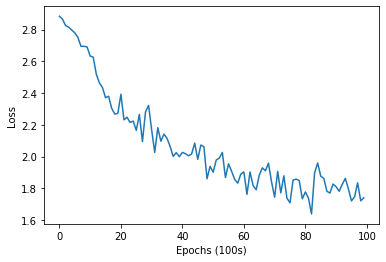

In [22]:
#Let's plot the loss we got during the training procedure
plt.figure()
plt.ylabel("Loss")
plt.xlabel('Epochs (100s)')
plt.plot(all_losses)

## 5. Step - Predict!
Great! We have successfully created our two models for bob and alice in parallel using federated learning! I experimented with federated averaging of the two models, but it turned out that for a batch size of 1, as in the present case, the model loss was diverging. Let's try using our models for prediction now, shall we? This is the final reward for our endeavours.

In [23]:
input_line = "Daniele"
model_remote = model_pointers["alice"]
line_tensor = lineToTensor(input_line)
line_tensor
line_remote = line_tensor.send(alice)
hidden = model_remote.initHidden()
hidden_remote = hidden.copy().send(alice)
hidden_remote
with torch.no_grad():
    for i in range(line_remote.shape[0]):
        output, hidden_remote = model_remote(line_remote[i], hidden_remote)
        
n_predictions = 3
topv, topi = output.copy().get().topk(n_predictions, 1, True)
topv

predictions = []


for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])



(-1.66) French
(-1.77) Dutch
(-1.99) English


In [24]:
def predict(model, input_line, worker, n_predictions=3):
    model = model.copy().get()
    print('\n> %s' % input_line)
    model_remote = model.send(worker)
    line_tensor = lineToTensor(input_line)
    line_remote = line_tensor.copy().send(worker)
    #line_tensor = lineToTensor(input_line)
    #output = evaluate(model, line_remote)
    # Get top N categories
    hidden = model_remote.initHidden()
    hidden_remote = hidden.copy().send(worker)
        
    with torch.no_grad():
        for i in range(line_remote.shape[0]):
            output, hidden_remote = model_remote(line_remote[i], hidden_remote)
        
    topv, topi = output.copy().get().topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i].item()
        category_index = topi[0][i].item()
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])



Notice how the different models learned may perform different predictions, based on the data that was shown to them.

In [25]:
predict(model_pointers["alice"], "Qing", alice) 




> Qing
(-0.65) Chinese
(-1.36) Korean
(-3.31) Arabic


You may try experimenting with this example right now, for example by increasing or decreasing the amount of epochs and seeing how the two models perform. You may also try to de-commenting the part about federating averaging and check the new resulting loss function. There can be lots of other optimizations we may think of as well!

# Congratulations!!! - Time to Join the Community!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement toward privacy preserving, decentralized ownership of AI and the AI supply chain (data), you can do so in the following ways!

### Star PySyft on GitHub

The easiest way to help our community is just by starring the Repos! This helps raise awareness of the cool tools we're building.

- [Star PySyft](https://github.com/OpenMined/PySyft)

### Join our Slack!

The best way to keep up to date on the latest advancements is to join our community! You can do so by filling out the form at [http://slack.openmined.org](http://slack.openmined.org)

### Join a Code Project!

The best way to contribute to our community is to become a code contributor! At any time you can go to PySyft GitHub Issues page and filter for "Projects". This will show you all the top level Tickets giving an overview of what projects you can join! If you don't want to join a project, but you would like to do a bit of coding, you can also look for more "one off" mini-projects by searching for GitHub issues marked "good first issue".

- [PySyft Projects](https://github.com/OpenMined/PySyft/issues?q=is%3Aopen+is%3Aissue+label%3AProject)
- [Good First Issue Tickets](https://github.com/OpenMined/PySyft/issues?q=is%3Aopen+is%3Aissue+label%3A%22good+first+issue%22)

### Donate

If you don't have time to contribute to our codebase, but would still like to lend support, you can also become a Backer on our Open Collective. All donations go toward our web hosting and other community expenses such as hackathons and meetups!

[OpenMined's Open Collective Page](https://opencollective.com/openmined)